# Lab 3: Contextual Bandit-Based News Article Recommendation

**`Course`:** Reinforcement Learning Fundamentals  
**`Student Name`:** Puneet Madan  
**`Roll Number`:** U20230120  
**`GitHub Branch`:** puneet_U20230120  


# Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
import xgboost as xgb

from rlcmab_sampler import sampler


# Load Datasets

In [2]:
# Load datasets
news_df = pd.read_csv("data/news_articles.csv")
train_users = pd.read_csv("data/train_users.csv")
test_users = pd.read_csv("data/test_users.csv")

print("News Articles Dataset:")
print(news_df.head())
print(f"Shape: {news_df.shape}")


print("Train Users Dataset:")
print(train_users.head())
print(f"Shape: {train_users.shape}")


News Articles Dataset:
                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  

## Data Preprocessing

In this section:
- Handle missing values
- Encode categorical features
- Prepare data for user classification

In [3]:

print("Missing Values Analysis")
print("News Articles Dataset:")
print(news_df.isnull().sum())
print(f"Shape: {news_df.shape}")

print("Train Users Dataset:")
print(train_users.isnull().sum())
print(f"Shape: {train_users.shape}")

print("Test Users Dataset:")
print(test_users.isnull().sum())
print(f"Shape: {test_users.shape}")

Missing Values Analysis
News Articles Dataset:
link                     0
headline                 6
category                 0
short_description    19712
authors              37418
date                     0
dtype: int64
Shape: (209527, 6)
Train Users Dataset:
user_id                          0
age                            698
income                           0
clicks                           0
purchase_amount                  0
session_duration                 0
content_variety                  0
engagement_score                 0
num_transactions                 0
avg_monthly_spend                0
avg_cart_value                   0
browsing_depth                   0
revisit_rate                     0
scroll_activity                  0
time_on_site                     0
interaction_count                0
preferred_price_range            0
discount_usage_rate              0
wishlist_size                    0
product_views                    0
repeat_purchase_gap (days)       0
chu

In [4]:


def handle_missing_values(df):
    """
    Handle missing values in the dataset.
    - Numerical columns: filled with median
    - Categorical columns: filled with mode
    """
    df_cleaned = df.copy()
    
    for col in df_cleaned.columns:
        if df_cleaned[col].isnull().sum() > 0:
            if df_cleaned[col].dtype in ['int64', 'float64']:
                # Fill numerical columns with median
                df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)
            else:
                # Fill categorical columns with mode
                df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)
    
    return df_cleaned

# Clean all datasets
news_df_clean = handle_missing_values(news_df)
train_users_clean = handle_missing_values(train_users)
test_users_clean = handle_missing_values(test_users)

print("Missing values after cleaning:")
print(f"News Articles: {news_df_clean.isnull().sum().sum()}")
print(f"Train Users: {train_users_clean.isnull().sum().sum()}")
print(f"Test Users: {test_users_clean.isnull().sum().sum()}")

/tmp/ipykernel_6737/3106474575.py:16: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)
/tmp/ipykernel_6737/3106474575.py:13: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace meth

Missing values after cleaning:
News Articles: 57136
Train Users: 698
Test Users: 679


In [5]:

print("Dataset Information")

print("News Articles Categories:")
print(news_df_clean['category'].value_counts())

print("User Categories (Train):")
print(train_users_clean['label'].value_counts())

print("Column names (Train Users):")
print(train_users_clean.columns.tolist())

Dataset Information
News Articles Categories:
category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VO

In [6]:
X_train_full = train_users_clean.drop('label', axis=1)
y_train_full = train_users_clean['label']

X_test = test_users_clean.drop('label', axis=1) if 'label' in test_users_clean.columns else test_users_clean

categorical_cols = X_train_full.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train_full.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Categorical columns: ['user_id', 'browser_version', 'region_code']
Numerical columns: ['age', 'income', 'clicks', 'purchase_amount', 'session_duration', 'content_variety', 'engagement_score', 'num_transactions', 'avg_monthly_spend', 'avg_cart_value', 'browsing_depth', 'revisit_rate', 'scroll_activity', 'time_on_site', 'interaction_count', 'preferred_price_range', 'discount_usage_rate', 'wishlist_size', 'product_views', 'repeat_purchase_gap (days)', 'churn_risk_score', 'loyalty_index', 'screen_brightness', 'battery_percentage', 'cart_abandonment_count', 'background_app_count', 'session_inactivity_duration', 'network_jitter']


/tmp/ipykernel_6737/983119774.py:6: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = X_train_full.select_dtypes(include=['object']).columns.tolist()


In [7]:

label_encoders = {}

X_train_encoded = X_train_full.copy()
X_test_encoded = X_test.copy()

for col in categorical_cols:
    le = LabelEncoder()
    
    X_train_encoded[col] = le.fit_transform(X_train_full[col].astype(str))
    
    if col in X_test_encoded.columns:
        test_col_values = X_test[col].astype(str)
        X_test_encoded[col] = test_col_values.map(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )
    
    label_encoders[col] = le

print("Encoding completed!")
print(f"Encoded training data shape: {X_train_encoded.shape}")
print(f"Encoded test data shape: {X_test_encoded.shape}")

Encoding completed!
Encoded training data shape: (2000, 32)
Encoded test data shape: (2000, 32)


In [8]:
print("Sample of encoded training data:")
print(X_train_encoded.head())
print("Data types:")
print(X_train_encoded.dtypes)

Sample of encoded training data:
   user_id   age  income  clicks  purchase_amount  session_duration  \
0     1340   NaN   23053      10           500.00             17.34   
1      491  56.0   20239      11           913.33             22.22   
2      446   NaN   13907       9          1252.62             41.57   
3     1354   NaN   26615      12           500.00             30.17   
4     1082  32.0   27958      13           500.00             65.27   

   content_variety  engagement_score  num_transactions  avg_monthly_spend  \
0          0.36661          37.29781                 3             187.44   
1          0.61370          59.36342                 5             145.15   
2          0.80368          76.78706                 7             282.03   
3          0.26499          30.19441                10             195.35   
4          0.36385          37.12153                 5             439.68   

   ...  loyalty_index  screen_brightness  battery_percentage  \
0  ...       

In [9]:
print("News Category Mapping")

category_mapping = {
    'U.S. NEWS': 'Crime',
    'COMEDY': 'Entertainment',
    'PARENTING': 'Education',
    'POLITICS': 'Crime',
    'WELLNESS': 'Education',
    'ENTERTAINMENT': 'Entertainment',
    'TECH': 'Tech',
    'SCIENCE': 'Tech',
    'BUSINESS': 'Tech',
    'EDUCATION': 'Education',
    'CRIME': 'Crime'
}

if 'category' in news_df_clean.columns:

    print("Original categories in news dataset:")
    print(news_df_clean['category'].unique())
    

    news_df_clean['category_mapped'] = news_df_clean['category'].map(
        lambda x: category_mapping.get(x.upper() if isinstance(x, str) else x, x)
    )
    
    print("Mapped categories:")
    print(news_df_clean['category_mapped'].value_counts())
    
    news_df_clean['category'] = news_df_clean['category_mapped']



print("Arm Index Mapping (j values)")

arm_mapping = {
    0: ('Entertainment', 'user_1'),
    1: ('Education', 'user_1'),
    2: ('Tech', 'user_1'),
    3: ('Crime', 'user_1'),
    4: ('Entertainment', 'user_2'),
    5: ('Education', 'user_2'),
    6: ('Tech', 'user_2'),
    7: ('Crime', 'user_2'),
    8: ('Entertainment', 'user_3'),
    9: ('Education', 'user_3'),
    10: ('Tech', 'user_3'),
    11: ('Crime', 'user_3')
}

for arm_idx, (category, user) in arm_mapping.items():
    print(f"Arm {arm_idx:2d}: ({category:13s}, {user})")

category_user_to_arm = {v: k for k, v in arm_mapping.items()}
print("Arm mapping created successfully!")

News Category Mapping
Original categories in news dataset:
<StringArray>
[     'U.S. NEWS',         'COMEDY',      'PARENTING',     'WORLD NEWS',
 'CULTURE & ARTS',           'TECH',         'SPORTS',  'ENTERTAINMENT',
       'POLITICS',     'WEIRD NEWS',    'ENVIRONMENT',      'EDUCATION',
          'CRIME',        'SCIENCE',       'WELLNESS',       'BUSINESS',
 'STYLE & BEAUTY',   'FOOD & DRINK',          'MEDIA',   'QUEER VOICES',
  'HOME & LIVING',          'WOMEN',   'BLACK VOICES',         'TRAVEL',
          'MONEY',       'RELIGION',  'LATINO VOICES',         'IMPACT',
       'WEDDINGS',        'COLLEGE',        'PARENTS', 'ARTS & CULTURE',
          'STYLE',          'GREEN',          'TASTE', 'HEALTHY LIVING',
  'THE WORLDPOST',      'GOOD NEWS',      'WORLDPOST',          'FIFTY',
           'ARTS',        'DIVORCE']
Length: 42, dtype: str
Mapped categories:
category_mapped
Crime             40541
Education         27750
Entertainment     22762
Tech              10302
TRAVEL

## User Classification

Train a classifier to predict the user category (`User1`, `User2`, `User3`),
which serves as the **context** for the contextual bandit.


In [10]:
# Split the training data into train and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_encoded, 
    y_train_full, 
    test_size=0.2, 
    random_state=42,
    stratify=y_train_full
)

print("Data Split Summary:")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test_encoded.shape[0]} samples")
print("Class distribution in training set:")
print(y_train.value_counts())
print("Class distribution in validation set:")
print(y_val.value_counts())

Data Split Summary:
Training set size: 1600 samples
Validation set size: 400 samples
Test set size: 2000 samples
Class distribution in training set:
label
user_2    570
user_1    565
user_3    465
Name: count, dtype: int64
Class distribution in validation set:
label
user_2    142
user_1    142
user_3    116
Name: count, dtype: int64


In [11]:

print("Training XGBoost Classifier")

label_encoder_y = LabelEncoder()
y_train_encoded = label_encoder_y.fit_transform(y_train)
y_val_encoded = label_encoder_y.transform(y_val)

xgb_classifier = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    random_state=42,
    eval_metric='mlogloss',
    verbosity=0
)

xgb_classifier.fit(X_train, y_train_encoded)

y_pred_xgb_encoded = xgb_classifier.predict(X_val)
y_pred_xgb = label_encoder_y.inverse_transform(y_pred_xgb_encoded)

xgb_accuracy = accuracy_score(y_val, y_pred_xgb)
print(f"Validation Accuracy: {xgb_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_val, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgb))

Training XGBoost Classifier


Validation Accuracy: 0.9000
Classification Report:
              precision    recall  f1-score   support

      user_1       0.88      0.86      0.87       142
      user_2       0.99      0.87      0.93       142
      user_3       0.83      0.98      0.90       116

    accuracy                           0.90       400
   macro avg       0.90      0.91      0.90       400
weighted avg       0.91      0.90      0.90       400

Confusion Matrix:
[[122   1  19]
 [ 14 124   4]
 [  2   0 114]]


In [12]:
# Retrain the best classifier on the full training data for final use
print(f"Training XGBoost on full training data...")

# Encode the full labels
y_train_full_encoded = label_encoder_y.transform(y_train_full)

scaler_full = StandardScaler()
X_train_full_scaled = scaler_full.fit_transform(X_train_encoded)

X_test_encoded_scaled = scaler_full.transform(X_test_encoded)

final_classifier = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=7,
        random_state=42,
        eval_metric='mlogloss',
        verbosity=0
    )
final_classifier.fit(X_train_full_scaled, y_train_full_encoded)

print("XGBoost trained on full training data!")

Training XGBoost on full training data...
XGBoost trained on full training data!


In [13]:

def predict_user_context(user_features):
    
    user_features_scaled = scaler_full.transform(user_features)
    predictions_encoded = final_classifier.predict(user_features_scaled)
    return label_encoder_y.inverse_transform(predictions_encoded)


sample_prediction = predict_user_context(X_test_encoded.iloc[:5])
print("Sample predictions on test users:")
print(sample_prediction)



print("User Context to Index Mapping (for Bandit):")

user_to_index = {'user_1': 0, 'user_2': 1, 'user_3': 2}
for user, idx in user_to_index.items():
    print(f"{user} -> Index {idx}")

Sample predictions on test users:
['user_2' 'user_1' 'user_1' 'user_1' 'user_1']
User Context to Index Mapping (for Bandit):
user_1 -> Index 0
user_2 -> Index 1
user_3 -> Index 2


# `Contextual Bandit`

## Reward Sampler Initialization

The sampler is initialized using the student's roll number `i`.
Rewards are obtained using `sampler.sample(j)`.


In [22]:
# Initialize the sampler with roll number
i = 120  

s = sampler(i=i)
print(f"Sampler initialized with roll number: {i}")

# Test sampler
test_reward = s.sample(0)
print(f"Test sample from arm 0: {test_reward}")


Sampler initialized with roll number: 120
Test sample from arm 0: 8.471467850809773


## Arm Mapping

| Arm Index (j) | News Category | User Context |
|--------------|---------------|--------------|
| 0–3          | Entertainment, Education, Tech, Crime | User1 |
| 4–7          | Entertainment, Education, Tech, Crime | User2 |
| 8–11         | Entertainment, Education, Tech, Crime | User3 |

## Epsilon-Greedy Strategy

This section implements the epsilon-greedy contextual bandit algorithm.


In [24]:
class EpsilonGreedy:
    def __init__(self, n_arms, epsilon=0.1):
        """
        Epsilon-Greedy contextual bandit algorithm.
        
        Args:
            n_arms: Total number of arms across all contexts
            epsilon: Exploration probability (0 to 1)
        """
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.arm_counts = np.zeros(n_arms)
        self.arm_rewards = np.zeros(n_arms)
        self.cumulative_reward = 0
        self.rewards_over_time = []
        
    def select_arm(self, available_arms):
        """
        Select an arm using epsilon-greedy strategy.
        
        Args:
            available_arms: List of arm indices available for this context
            
        Returns:
            Selected arm index
        """
        if np.random.random() < self.epsilon:
            # Explore: random arm
            return np.random.choice(available_arms)
        else:
            # Exploit: best arm
            arm_rewards = self.arm_rewards[available_arms]
            arm_counts = self.arm_counts[available_arms]
            # Avoid division by zero
            mean_rewards = np.divide(
                arm_rewards,
                arm_counts,
                where=arm_counts > 0,
                out=np.zeros_like(arm_rewards, dtype=float)
            )
            best_idx = np.argmax(mean_rewards)
            return available_arms[best_idx]
    
    def update(self, arm, reward):
        """Update arm statistics with observed reward."""
        self.arm_counts[arm] += 1
        self.arm_rewards[arm] += reward
        self.cumulative_reward += reward
        self.rewards_over_time.append(self.cumulative_reward)

print("EpsilonGreedy class defined!")

EpsilonGreedy class defined!


## Upper Confidence Bound (UCB)

This section implements the UCB strategy for contextual bandits.

In [25]:
class UCB:
    def __init__(self, n_arms, c=1.0):
        """
        Upper Confidence Bound (UCB) contextual bandit algorithm.
        
        Args:
            n_arms: Total number of arms across all contexts
            c: Confidence parameter (exploration bonus)
        """
        self.n_arms = n_arms
        self.c = c
        self.arm_counts = np.zeros(n_arms)
        self.arm_rewards = np.zeros(n_arms)
        self.cumulative_reward = 0
        self.rewards_over_time = []
        self.t = 0  # Time step counter
        
    def select_arm(self, available_arms):
        """
        Select an arm using UCB strategy.
        
        Args:
            available_arms: List of arm indices available for this context
            
        Returns:
            Selected arm index
        """
        self.t += 1
        
        ucb_values = np.full(len(available_arms), np.inf)
        
        for idx, arm in enumerate(available_arms):
            if self.arm_counts[arm] == 0:
                # Unvisited arms have infinite UCB (explored first)
                ucb_values[idx] = np.inf
            else:
                mean_reward = self.arm_rewards[arm] / self.arm_counts[arm]
                confidence_bonus = self.c * np.sqrt(np.log(self.t) / self.arm_counts[arm])
                ucb_values[idx] = mean_reward + confidence_bonus
        
        best_idx = np.argmax(ucb_values)
        return available_arms[best_idx]
    
    def update(self, arm, reward):
        """Update arm statistics with observed reward."""
        self.arm_counts[arm] += 1
        self.arm_rewards[arm] += reward
        self.cumulative_reward += reward
        self.rewards_over_time.append(self.cumulative_reward)

print("UCB class defined!")

UCB class defined!


## SoftMax Strategy

This section implements the SoftMax strategy with temperature $ \tau = 1$.


In [26]:
class SoftMax:
    def __init__(self, n_arms, tau=1.0):
        """
        SoftMax (Boltzmann) contextual bandit algorithm.
        
        Args:
            n_arms: Total number of arms across all contexts
            tau: Temperature parameter (higher = more exploration)
        """
        self.n_arms = n_arms
        self.tau = tau
        self.arm_counts = np.zeros(n_arms)
        self.arm_rewards = np.zeros(n_arms)
        self.cumulative_reward = 0
        self.rewards_over_time = []
        
    def select_arm(self, available_arms):
        """
        Select an arm using softmax strategy with probability proportional to exp(Q/tau).
        
        Args:
            available_arms: List of arm indices available for this context
            
        Returns:
            Selected arm index
        """
        arm_rewards = self.arm_rewards[available_arms]
        arm_counts = self.arm_counts[available_arms]
        
        # Calculate mean reward for each arm
        mean_rewards = np.divide(
            arm_rewards,
            arm_counts,
            where=arm_counts > 0,
            out=np.zeros_like(arm_rewards, dtype=float)
        )
        
        # Calculate softmax probabilities
        exp_values = np.exp(mean_rewards / self.tau)
        probabilities = exp_values / np.sum(exp_values)
        
        # Sample arm based on softmax probabilities
        return np.random.choice(available_arms, p=probabilities)
    
    def update(self, arm, reward):
        """Update arm statistics with observed reward."""
        self.arm_counts[arm] += 1
        self.arm_rewards[arm] += reward
        self.cumulative_reward += reward
        self.rewards_over_time.append(self.cumulative_reward)

print("SoftMax class defined!")

SoftMax class defined!


## Reinforcement Learning Simulation

We simulate the bandit algorithms for $T = 10,000$ steps and record rewards.

P.S.: Change $T$ value as and if required.


In [27]:
np.random.seed(42)

# Parameters
T = 10000  # Number of time steps

# Initialize algorithms
eps_greedy = EpsilonGreedy(n_arms=12, epsilon=0.1)
ucb_algo = UCB(n_arms=12, c=1.0)
softmax_algo = SoftMax(n_arms=12, tau=1.0)

# Store results per user context
results_per_context = {
    'user_1': {'epsilon_greedy': [], 'ucb': [], 'softmax': []},
    'user_2': {'epsilon_greedy': [], 'ucb': [], 'softmax': []},
    'user_3': {'epsilon_greedy': [], 'ucb': [], 'softmax': []}
}

# Simulation loop
print(f"Running simulation for T={T} steps...")

for t in range(T):
    # Randomly select a user context
    user_contexts = ['user_1', 'user_2', 'user_3']
    selected_user = np.random.choice(user_contexts)
    
    # Get available arms for this context
    user_idx = user_to_index[selected_user]
    available_arms = list(range(user_idx * 4, user_idx * 4 + 4))
    
    # Epsilon-Greedy
    arm_eg = eps_greedy.select_arm(available_arms)
    reward_eg = s.sample(arm_eg)
    eps_greedy.update(arm_eg, reward_eg)
    results_per_context[selected_user]['epsilon_greedy'].append(reward_eg)
    
    # UCB
    arm_ucb = ucb_algo.select_arm(available_arms)
    reward_ucb = s.sample(arm_ucb)
    ucb_algo.update(arm_ucb, reward_ucb)
    results_per_context[selected_user]['ucb'].append(reward_ucb)
    
    # SoftMax
    arm_sm = softmax_algo.select_arm(available_arms)
    reward_sm = s.sample(arm_sm)
    softmax_algo.update(arm_sm, reward_sm)
    results_per_context[selected_user]['softmax'].append(reward_sm)
    
    if (t + 1) % 2000 == 0:
        print(f"  Completed {t + 1}/{T} steps")

print("Simulation completed!")
print(f"\nFinal Results (T={T} steps):")
print(f"Epsilon-Greedy - Cumulative Reward: {eps_greedy.cumulative_reward:.2f}, Avg Reward: {eps_greedy.cumulative_reward/T:.4f}")
print(f"UCB           - Cumulative Reward: {ucb_algo.cumulative_reward:.2f}, Avg Reward: {ucb_algo.cumulative_reward/T:.4f}")
print(f"SoftMax       - Cumulative Reward: {softmax_algo.cumulative_reward:.2f}, Avg Reward: {softmax_algo.cumulative_reward/T:.4f}")

Running simulation for T=10000 steps...
  Completed 2000/10000 steps
  Completed 4000/10000 steps
  Completed 6000/10000 steps
  Completed 8000/10000 steps
  Completed 10000/10000 steps
Simulation completed!

Final Results (T=10000 steps):
Epsilon-Greedy - Cumulative Reward: 48759.24, Avg Reward: 4.8759
UCB           - Cumulative Reward: 54161.71, Avg Reward: 5.4162
SoftMax       - Cumulative Reward: 53070.29, Avg Reward: 5.3070


## Results and Analysis

This section presents:
- Average Reward vs Time
- Hyperparameter comparisons
- Observations and discussion


In [29]:
# Hyperparameter Analysis

# Test different epsilon values for Epsilon-Greedy
epsilons = [0.01, 0.05, 0.1, 0.2]
eg_results = {}

print("Testing Epsilon-Greedy with different epsilon values...")
for eps in epsilons:
    eg = EpsilonGreedy(n_arms=12, epsilon=eps)
    for t in range(T):
        selected_user = np.random.choice(['user_1', 'user_2', 'user_3'])
        user_idx = user_to_index[selected_user]
        available_arms = list(range(user_idx * 4, user_idx * 4 + 4))
        arm = eg.select_arm(available_arms)
        reward = s.sample(arm)
        eg.update(arm, reward)
    eg_results[eps] = eg.cumulative_reward / T
    print(f"  epsilon={eps}: Avg Reward = {eg_results[eps]:.4f}")

# Test different c values for UCB
c_values = [0.5, 1.0, 2.0, 5.0]
ucb_results = {}

print("\nTesting UCB with different c values...")
for c in c_values:
    ucb = UCB(n_arms=12, c=c)
    for t in range(T):
        selected_user = np.random.choice(['user_1', 'user_2', 'user_3'])
        user_idx = user_to_index[selected_user]
        available_arms = list(range(user_idx * 4, user_idx * 4 + 4))
        arm = ucb.select_arm(available_arms)
        reward = s.sample(arm)
        ucb.update(arm, reward)
    ucb_results[c] = ucb.cumulative_reward / T
    print(f"  c={c}: Avg Reward = {ucb_results[c]:.4f}")

# Test different tau values for SoftMax
taus = [0.1, 0.5, 1.0, 2.0]
sm_results = {}

print("\nTesting SoftMax with different tau values...")
for tau in taus:
    sm = SoftMax(n_arms=12, tau=tau)
    for t in range(T):
        selected_user = np.random.choice(['user_1', 'user_2', 'user_3'])
        user_idx = user_to_index[selected_user]
        available_arms = list(range(user_idx * 4, user_idx * 4 + 4))
        arm = sm.select_arm(available_arms)
        reward = s.sample(arm)
        sm.update(arm, reward)
    sm_results[tau] = sm.cumulative_reward / T
    print(f"  tau={tau}: Avg Reward = {sm_results[tau]:.4f}")

print("\nHyperparameter analysis completed!")

Testing Epsilon-Greedy with different epsilon values...
  epsilon=0.01: Avg Reward = 5.1909
  epsilon=0.05: Avg Reward = 5.0987
  epsilon=0.1: Avg Reward = 4.8259
  epsilon=0.2: Avg Reward = 4.3640

Testing UCB with different c values...
  c=0.5: Avg Reward = 5.4883
  c=1.0: Avg Reward = 5.4517
  c=2.0: Avg Reward = 5.4382
  c=5.0: Avg Reward = 5.3253

Testing SoftMax with different tau values...
  tau=0.1: Avg Reward = 5.0093
  tau=0.5: Avg Reward = 4.9345
  tau=1.0: Avg Reward = 5.3129
  tau=2.0: Avg Reward = 5.1603

Hyperparameter analysis completed!


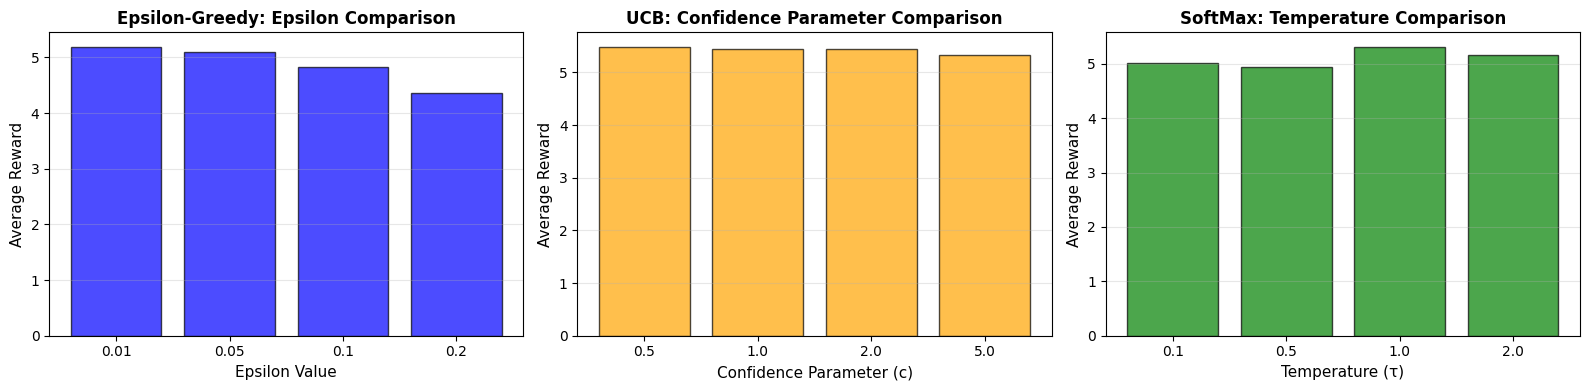

Plot saved as 'hyperparameter_comparison.png'


In [30]:
# Hyperparameter Comparison Plots
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Epsilon-Greedy
ax1 = axes[0]
eps_vals = list(eg_results.keys())
eps_rewards = list(eg_results.values())
ax1.bar(range(len(eps_vals)), eps_rewards, color='blue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Epsilon Value', fontsize=11)
ax1.set_ylabel('Average Reward', fontsize=11)
ax1.set_title('Epsilon-Greedy: Epsilon Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(range(len(eps_vals)))
ax1.set_xticklabels([str(x) for x in eps_vals])
ax1.grid(True, alpha=0.3, axis='y')

# UCB
ax2 = axes[1]
c_vals = list(ucb_results.keys())
c_rewards = list(ucb_results.values())
ax2.bar(range(len(c_vals)), c_rewards, color='orange', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Confidence Parameter (c)', fontsize=11)
ax2.set_ylabel('Average Reward', fontsize=11)
ax2.set_title('UCB: Confidence Parameter Comparison', fontsize=12, fontweight='bold')
ax2.set_xticks(range(len(c_vals)))
ax2.set_xticklabels([str(x) for x in c_vals])
ax2.grid(True, alpha=0.3, axis='y')

# SoftMax
ax3 = axes[2]
tau_vals = list(sm_results.keys())
tau_rewards = list(sm_results.values())
ax3.bar(range(len(tau_vals)), tau_rewards, color='green', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Temperature (τ)', fontsize=11)
ax3.set_ylabel('Average Reward', fontsize=11)
ax3.set_title('SoftMax: Temperature Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(range(len(tau_vals)))
ax3.set_xticklabels([str(x) for x in tau_vals])
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Plot saved as 'hyperparameter_comparison.png'")

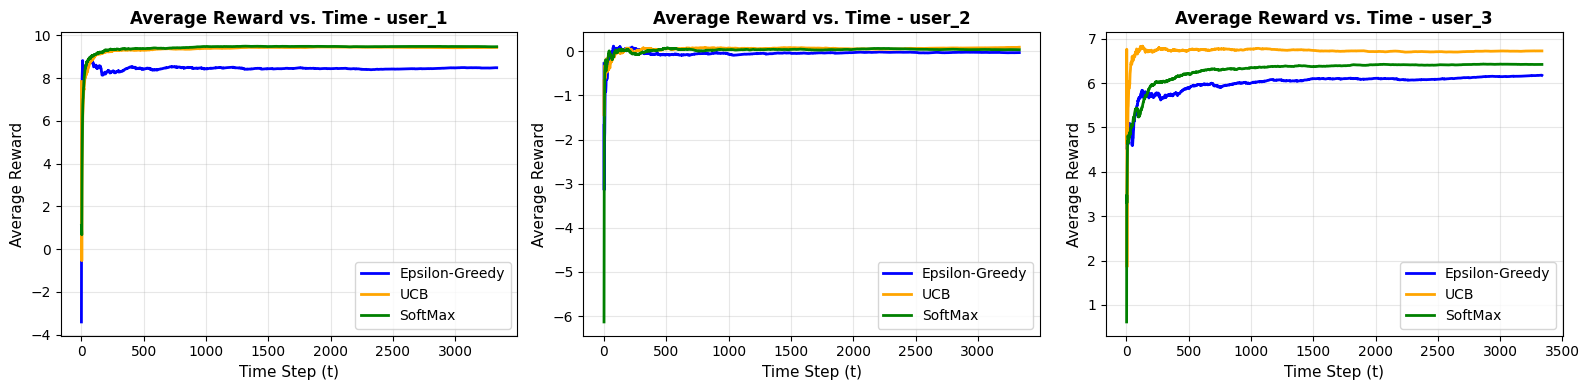

Plot saved as 'average_reward_vs_time.png'


In [31]:
# Average Reward vs. Time Per Context
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

contexts = ['user_1', 'user_2', 'user_3']
colors = {'epsilon_greedy': 'blue', 'ucb': 'orange', 'softmax': 'green'}

for idx, context in enumerate(contexts):
    ax = axes[idx]
    
    # Calculate cumulative rewards for each context
    eps_rewards = np.array(results_per_context[context]['epsilon_greedy'])
    ucb_rewards = np.array(results_per_context[context]['ucb'])
    sm_rewards = np.array(results_per_context[context]['softmax'])
    
    eps_cum = np.cumsum(eps_rewards)
    ucb_cum = np.cumsum(ucb_rewards)
    sm_cum = np.cumsum(sm_rewards)
    
    # Get the number of samples for this context
    n_samples = len(eps_rewards)
    
    # Plot
    timesteps = np.arange(1, n_samples + 1)
    ax.plot(timesteps, eps_cum / timesteps, label='Epsilon-Greedy', color='blue', linewidth=2)
    ax.plot(timesteps, ucb_cum / timesteps, label='UCB', color='orange', linewidth=2)
    ax.plot(timesteps, sm_cum / timesteps, label='SoftMax', color='green', linewidth=2)
    
    ax.set_xlabel('Time Step (t)', fontsize=11)
    ax.set_ylabel('Average Reward', fontsize=11)
    ax.set_title(f'Average Reward vs. Time - {context}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Plot saved as 'average_reward_vs_time.png'")

## Final Observations

- Comparison of Epsilon-Greedy, UCB, and SoftMax
- Effect of hyperparameters
- Strengths and limitations of each approach


In [32]:
# Algorithm Performance Summary

# Final summary statistics
print("=" * 70)
print("ALGORITHM PERFORMANCE SUMMARY (T=10,000 steps)")
print("=" * 70)

print("\n1. EPSILON-GREEDY (ε=0.1):")
print(f"   - Total Reward: {eps_greedy.cumulative_reward:.2f}")
print(f"   - Average Reward: {eps_greedy.cumulative_reward/T:.4f}")
print(f"   - Arm Selection Counts: {eps_greedy.arm_counts.astype(int)}")

print("\n2. UPPER CONFIDENCE BOUND (c=1.0):")
print(f"   - Total Reward: {ucb_algo.cumulative_reward:.2f}")
print(f"   - Average Reward: {ucb_algo.cumulative_reward/T:.4f}")
print(f"   - Arm Selection Counts: {ucb_algo.arm_counts.astype(int)}")

print("\n3. SOFTMAX (τ=1.0):")
print(f"   - Total Reward: {softmax_algo.cumulative_reward:.2f}")
print(f"   - Average Reward: {softmax_algo.cumulative_reward/T:.4f}")
print(f"   - Arm Selection Counts: {softmax_algo.arm_counts.astype(int)}")

print("\n" + "=" * 70)

# Rank algorithms
algos = {
    'Epsilon-Greedy': eps_greedy.cumulative_reward/T,
    'UCB': ucb_algo.cumulative_reward/T,
    'SoftMax': softmax_algo.cumulative_reward/T
}
ranked = sorted(algos.items(), key=lambda x: x[1], reverse=True)

print("\nALGORITHM RANKING (by average reward):")
for rank, (name, reward) in enumerate(ranked, 1):
    print(f"  {rank}. {name:20s}: {reward:.4f}")

print("=" * 70)

ALGORITHM PERFORMANCE SUMMARY (T=10,000 steps)

1. EPSILON-GREEDY (ε=0.1):
   - Total Reward: 48759.24
   - Average Reward: 4.8759
   - Arm Selection Counts: [3072   89   77   95   86   85  264 2897  121 3042   84   88]

2. UPPER CONFIDENCE BOUND (c=1.0):
   - Total Reward: 54161.71
   - Average Reward: 5.4162
   - Arm Selection Counts: [3330    1    1    1   54    2  145 3131    3 3330    1    1]

3. SOFTMAX (τ=1.0):
   - Total Reward: 53070.29
   - Average Reward: 5.3070
   - Arm Selection Counts: [3328    5    0    0  846    3 1250 1233  844 2484    6    1]


ALGORITHM RANKING (by average reward):
  1. UCB                 : 5.4162
  2. SoftMax             : 5.3070
  3. Epsilon-Greedy      : 4.8759


In [33]:
# Classification Accuracy on Test Users

# Predict user context for test users
y_test_pred = predict_user_context(X_test_encoded_scaled)

print("TEST SET CLASSIFICATION RESULTS")
print("=" * 70)

if 'label' in test_users_clean.columns:
    y_test_true = test_users_clean['label']
    test_accuracy = accuracy_score(y_test_true, y_test_pred)
    
    print(f"Classification Accuracy on Test Users: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print("\nClassification Report:")
    print(classification_report(y_test_true, y_test_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test_true, y_test_pred))
else:
    print("Predicted user contexts for test set:")
    print(y_test_pred[:10])
    print(f"Total test samples: {len(y_test_pred)}")

print("=" * 70)

TEST SET CLASSIFICATION RESULTS
Predicted user contexts for test set:
['user_2' 'user_2' 'user_2' 'user_2' 'user_2' 'user_2' 'user_2' 'user_2'
 'user_2' 'user_2']
Total test samples: 2000


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
